In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import transforms, utils
from torch.utils.data import DataLoader, TensorDataset

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2


from datasets_local import gaussian_mixture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [2]:

from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 100

pretrained_model = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))
pretrained_model.eval()

MaskedDiffusion(
  (denoising_model): UNetWithAttention(
    (embedding): Embedding(3, 64)
    (time_embedding): SinusoidalPosEmb()
    (temb_mlp): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): NonLinearity()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NonLinearity()
    )
    (initial_block): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResNetBlock(
          (norm1): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin1): NonLinearity()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin2): NonLinearity()
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), str

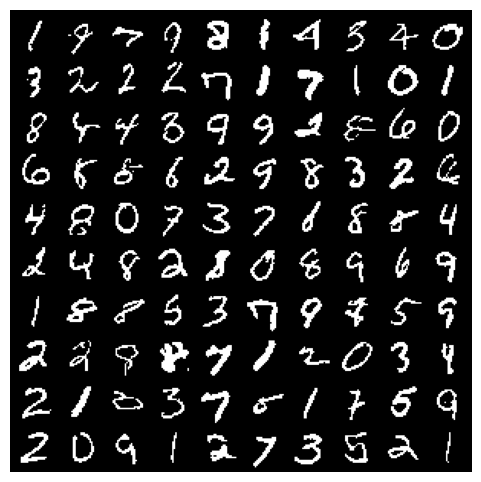

In [3]:
# Visualize samples
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [4]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch
mnist_classfier_model = BinarizedMNISTClassifier().to(device)
mnist_classfier_model.load_state_dict(torch.load('../model_weights/binarized_mnist_classifier_1.pth'))

def compute_rewards_for_batch(x: Tensor, with_grad=False):
    # x.shape : (B, 1, 28, 28, num_categories)
    logits = mnist_classfier_model(x[..., :vocab_size].to(device)) # Shape: (B, 10)
    logits = logits.log_softmax(dim=-1) # Shape: (B, 10)
    reward = logits[:, 4]
    return reward

def compute_rewards(x, with_grad=False):
    n_samples = x.shape[0]
    rewards_all = []
    for i in range(0, n_samples, batch_size):
        if with_grad:
            rewards = compute_rewards_for_batch(x[i:i + batch_size])
        else:
            with torch.no_grad():
                rewards = compute_rewards_for_batch(x[i:i + batch_size])
        rewards_all.append(rewards)
    rewards_all = torch.cat(rewards_all)
    return rewards_all

kl_weight = 0.1

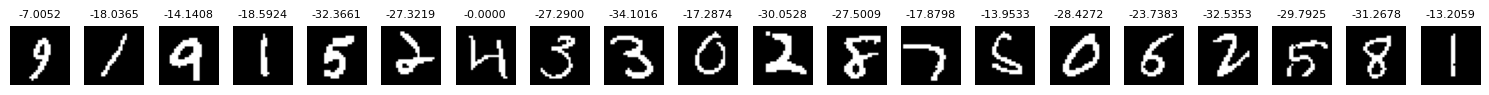

In [5]:
# Visualize rewards
from datasets_local.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=20)
samples, _ = next(iter(train_loader))
rewards = compute_rewards(F.one_hot(samples.long(), num_classes=num_categories).float())

fig, axes = plt.subplots(1, 20, figsize=(15, 2))
for i in range(20):
    ax = axes[i]
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(f"{rewards[i].item():.4f}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

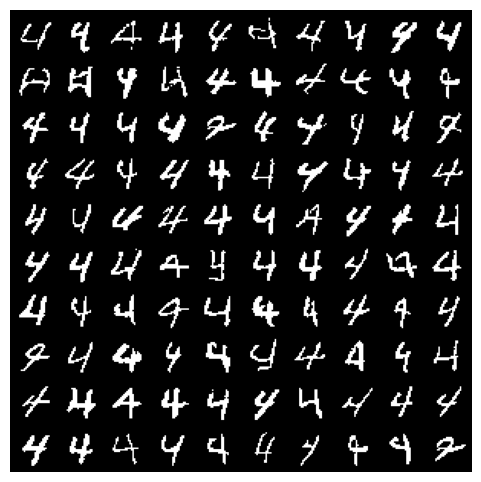

Target Reward: -0.0022584672551602125
Diversity: 95


In [6]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    dataset = torch.load("pretrained_mnist_samples_dataset.pt", weights_only=False)
    train_loader = DataLoader(dataset, batch_size)
    log_pdf_values = []
    for samples, _ in train_loader:
        samples = samples.long()
        log_pdf_values.append(target_distribution_log_pdf(samples, kl_weight))
    log_pdf_values = torch.cat(log_pdf_values, dim=0)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return torch.stack([train_loader.dataset[i][0].long() for i in indices])

target_samples = sample_target_distribution(100, kl_weight)

grid = utils.make_grid(target_samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().float().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

target_rewards = compute_rewards(
    F.one_hot(target_samples, num_classes=num_categories).float()
)
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {torch.unique(target_samples, dim=0).shape[0]}")

# SDPO

Intialize dataset of clean samples generated from the pretrained model and the rewards

In [8]:
# These are 10,000 saved samples generated from the pretrained model
dataset = torch.load("pretrained_mnist_samples_dataset.pt", weights_only=False)

Intialize model to optimize

In [9]:
model = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
model.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))
model.eval()

MaskedDiffusion(
  (denoising_model): UNetWithAttention(
    (embedding): Embedding(3, 64)
    (time_embedding): SinusoidalPosEmb()
    (temb_mlp): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): NonLinearity()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NonLinearity()
    )
    (initial_block): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): ResNetBlock(
          (norm1): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin1): NonLinearity()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): Normalizaton(
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
          )
          (non_lin2): NonLinearity()
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), str

In [10]:
batch_size = 100
lr = 0.0005
data_loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10
ckpt_path = '../model_weights/sdpo_correct_mdm_binarized_mnist.pth'

100it [01:01,  1.63it/s]


Epoch 1/10,  Loss: 4.721100082397461


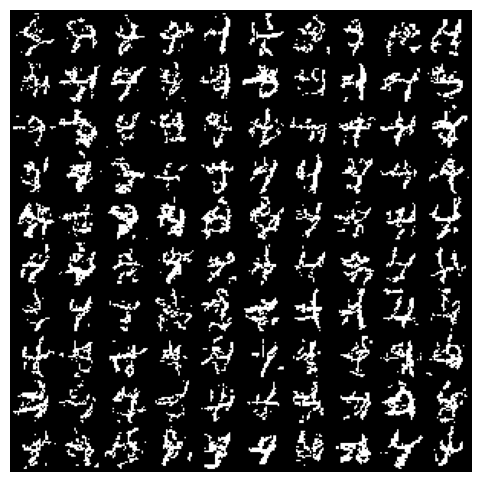

Reward: -1.5371673107147217
Saved model weights.


100it [01:05,  1.53it/s]


Epoch 2/10,  Loss: 4.772891340255737


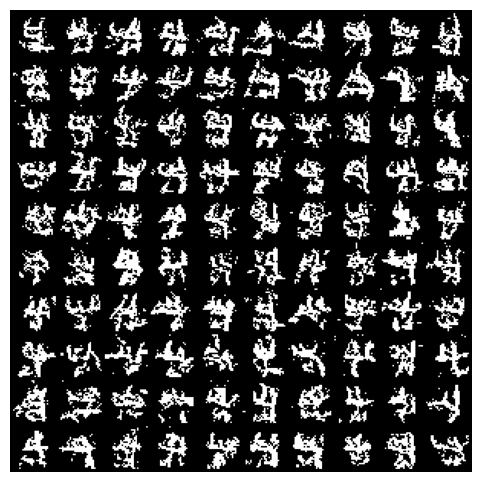

Reward: -0.770934522151947
Saved model weights.


100it [01:07,  1.48it/s]


Epoch 3/10,  Loss: 4.913620495796204


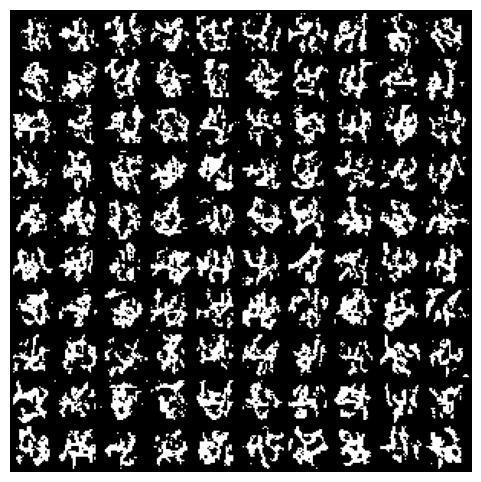

Reward: -2.4354424476623535


100it [01:09,  1.45it/s]


Epoch 4/10,  Loss: 4.88134581565857


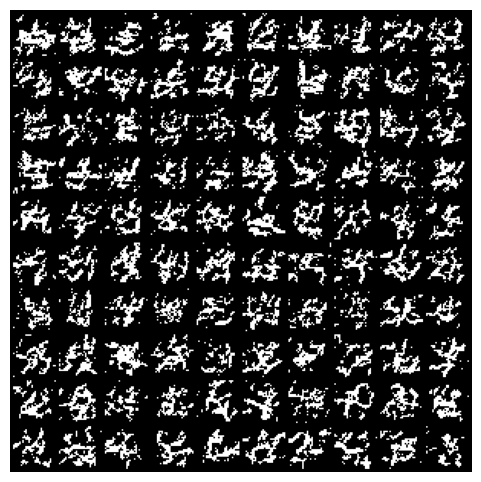

Reward: -3.5800111293792725


100it [01:07,  1.48it/s]


Epoch 5/10,  Loss: 4.763652906417847


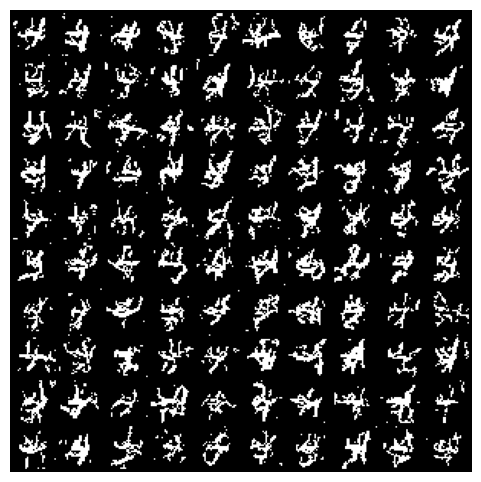

Reward: -0.1681152880191803
Saved model weights.


100it [01:08,  1.47it/s]


Epoch 6/10,  Loss: 4.770535912513733


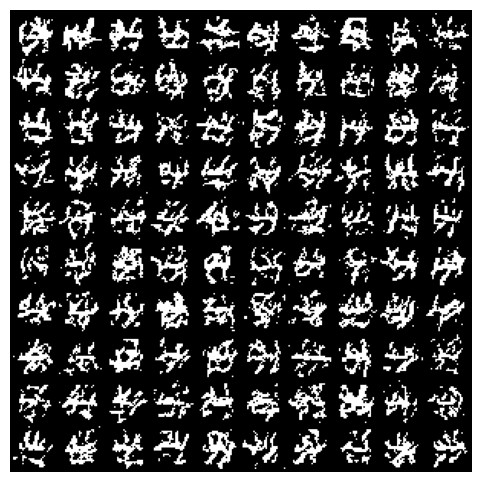

Reward: -1.2897801399230957


100it [01:08,  1.47it/s]


Epoch 7/10,  Loss: 4.7373099040985105


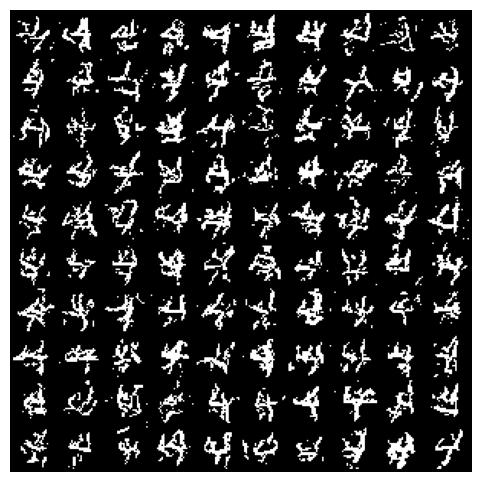

Reward: -0.3482804000377655


100it [01:08,  1.47it/s]


Epoch 8/10,  Loss: 4.6216909170150755


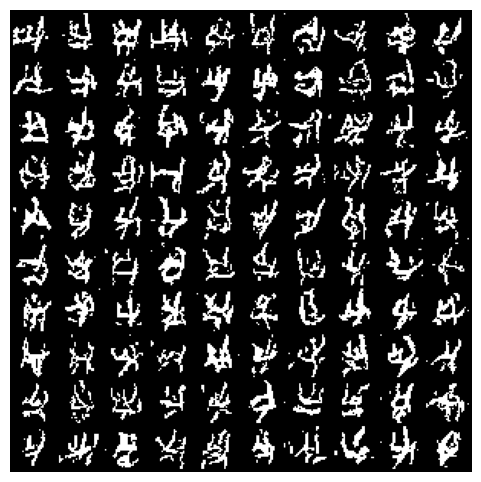

Reward: -0.28907474875450134


100it [01:09,  1.43it/s]


Epoch 9/10,  Loss: 4.607359838485718


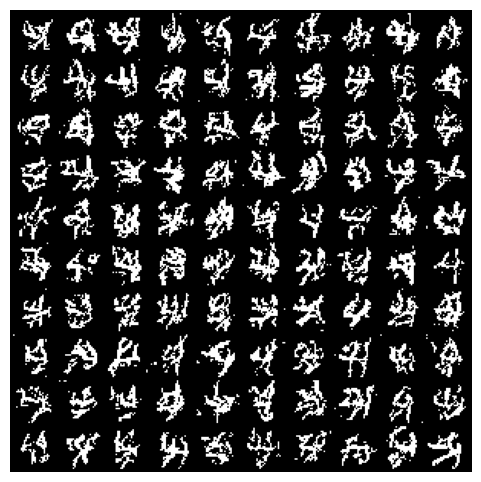

Reward: -0.5590248703956604


100it [01:11,  1.40it/s]


Epoch 10/10,  Loss: 5.299645528793335


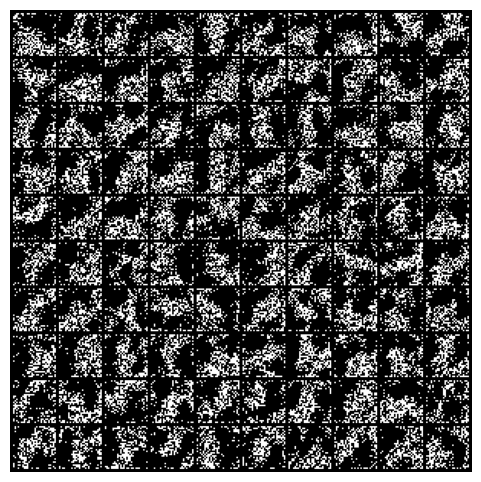

Reward: -4.198625564575195


In [11]:
loss_trace = []
reward_trace = []

for epoch in range(num_epochs):
    total_loss, n_batches = 0.0, 0
    
    num_x0_samples_per_xt = 100
    
    model.train()
    for batch_idx, (saved_x0_samples, _) in tqdm(enumerate(data_loader)):
        optimizer.zero_grad()
        N = len(saved_x0_samples)
        
        t = torch.rand(N, device=device)
        with torch.no_grad():
            xt_samples = pretrained_model.get_z_t_from_x(saved_x0_samples.to(device), t)
        
        model_x_theta = torch.distributions.Categorical(
            probs=model.get_x_theta_from_z_t(xt_samples, t).unsqueeze(1).expand(-1, num_x0_samples_per_xt, -1, -1, -1, -1)
        )
        with torch.no_grad():
            pretrained_model_x_theta = torch.distributions.Categorical(
                probs=pretrained_model.get_x_theta_from_z_t(xt_samples, t).unsqueeze(1).expand(-1, num_x0_samples_per_xt, -1, -1, -1, -1)
            )
            x0_samples = pretrained_model_x_theta.sample() # Shape: (N, num_x0_samples_per_xt, 1, 28, 28)
            x0_rewards = compute_rewards(
                F.one_hot(x0_samples.reshape(-1, *input_shape), num_classes=num_categories).float()
            ).reshape(N, num_x0_samples_per_xt)
        
        alpha_t = pretrained_model.scheduler.alpha(t) # Shape: (N,)
        beta_t = kl_weight / (1 - alpha_t) # Shape: (N,)
        
        # print(f"t: {t}, alpha_t: {alpha_t}, beta_t: {beta_t}")
        
        model_rewards = beta_t.unsqueeze(1) * (
            model_x_theta.log_prob(x0_samples).sum(dim=(2, 3, 4)) - 
            pretrained_model_x_theta.log_prob(x0_samples).sum(dim=(2, 3, 4))
        ) # Shape: (N, num_x0_samples_per_xt)
        
        loss = -1.0 * (
            F.softmax(x0_rewards, dim=1) * F.log_softmax(model_rewards, dim=1)
        ).sum(dim=1).mean(dim=0)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    model.eval()
    
    avg_loss = total_loss / n_batches
    print(f"Epoch {epoch+1}/{num_epochs},  Loss: {avg_loss}")
    loss_trace.append(avg_loss)

    with torch.no_grad():
        model_samples = model.sample(num_samples=100, device=device).cpu()
    grid = utils.make_grid(model_samples.float(), nrow=10, padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
    plt.axis('off')
    plt.show()

    rewards = compute_rewards(F.one_hot(model_samples, num_classes=num_categories).float())
    print(f"Reward: {rewards.mean().item()}")
    reward_trace.append(rewards.mean().item())
    
    if reward_trace[-1] == max(reward_trace):
        # store model weights
        torch.save(model.state_dict(), ckpt_path)
        print("Saved model weights.")

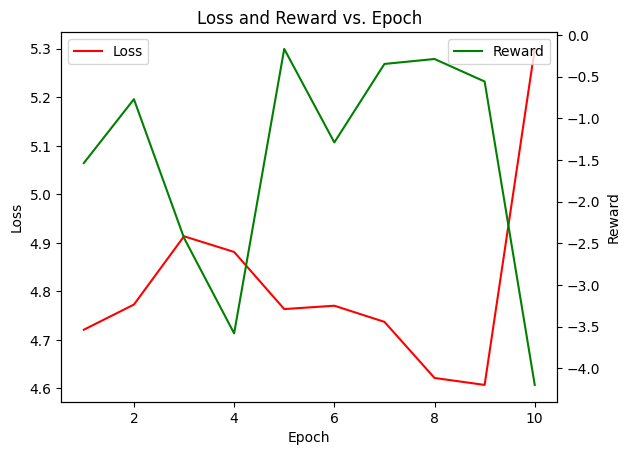

In [13]:
import matplotlib.pyplot as plt

# loss_trace and reward_trace are 1D lists (or 1D arrays) of the same length
epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.show()

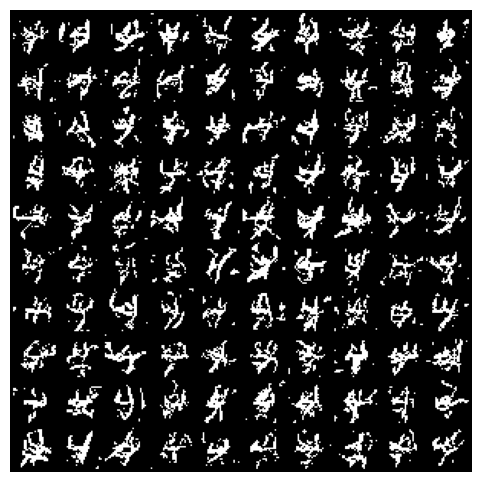

In [16]:
model.load_state_dict(torch.load(ckpt_path))
# Visualize samples from the finetuned model
with torch.no_grad():
    samples = model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

Mixture model:
$\tilde{p}_\theta(x_0|x_t,c)\propto p_\mathrm{ref}(x_0|x_t,c)^{(1-\beta_t)}p_\theta(x_0|x_t,c)^{\beta_t}$ 

https://arxiv.org/pdf/2507.04832

In [34]:
def sample_mixture_model(num_samples: int = 1, device=torch.device('cpu')) -> Tensor:
    N = num_categories
    z_t = torch.full((num_samples, *input_shape), mask_index, device=device)
    B = z_t.shape[0]
    z_t = z_t.reshape(B, -1) # Shape: (B, L)
    
    for i in range(num_timesteps, 0, -1):
        p_theta, _ = sample_step_mixture_model(F.one_hot(z_t, num_classes=N).float(), i, device)
        
        # 3. Sample z_s from p_theta
        z_s = torch.distributions.Categorical(probs=p_theta).sample() # Shape: (B, L)
        
        z_t = z_s
    
    x = z_t.reshape(B, *input_shape)
    # Sanity check - the final sample should not have any masked tokens
    assert torch.all(x != mask_index)
    return x

def sample_step_mixture_model(z_t: Tensor, i: int, device=torch.device('cpu')) -> tuple[Tensor, Tensor]:
    B, L, N = z_t.shape
    
    t = pretrained_model.discrete_time_scheduler.discrete_time(i).to(device)
    s = pretrained_model.discrete_time_scheduler.discrete_time(i - 1).to(device)
    alpha_t = pretrained_model.scheduler.alpha(t)
    alpha_s = pretrained_model.scheduler.alpha(s)

    # 1. Calculate x_theta
    x_theta_pretrained = pretrained_model.denoising_model(
        z_t.reshape(B, *input_shape, N), 
        torch.full((B,), t.item(), device=device)
    )
    x_theta_pretrained = x_theta_pretrained.reshape(B, L, N)
    x_theta_model = model.denoising_model(
        z_t.reshape(B, *input_shape, N), 
        torch.full((B,), t.item(), device=device)
    )
    x_theta_model = x_theta_model.reshape(B, L, N)
    
    # 2. Create mixture
    # beta_t = kl_weight / (1 - alpha_t)
    beta_t = 0.8
    x_theta_logits = torch.where(
        x_theta_pretrained * x_theta_model == 0,
        -torch.inf,
        (1-beta_t) * torch.log(x_theta_pretrained) + beta_t * torch.log(x_theta_model)
    )
    x_theta = F.softmax(x_theta_logits, dim=-1)

    # 3. Calculate p_theta
    p_theta = ((1 - alpha_s) * z_t + (alpha_s - alpha_t) * x_theta) /  (1 - alpha_t)

    # Sanity check - probabilities should sum up to 1
    assert torch.allclose(x_theta.sum(dim=-1), torch.ones(B, L, device=device)), f"Max = {torch.abs(x_theta.sum(dim=-1) - torch.ones(B, L, device=device)).max()}"
    assert torch.allclose(p_theta.sum(dim=-1), torch.ones(B, L, device=device)), f"Max = {torch.abs(p_theta.sum(dim=-1) - torch.ones(B, L, device=device)).max()}"
    # Sanity check - probabilities should be non-negative
    assert torch.all(x_theta >= 0), f"Min = {x_theta.min()}, {t}"
    assert torch.all(p_theta >= 0), f"Min = {p_theta.min()}, {t}"
    return p_theta, x_theta

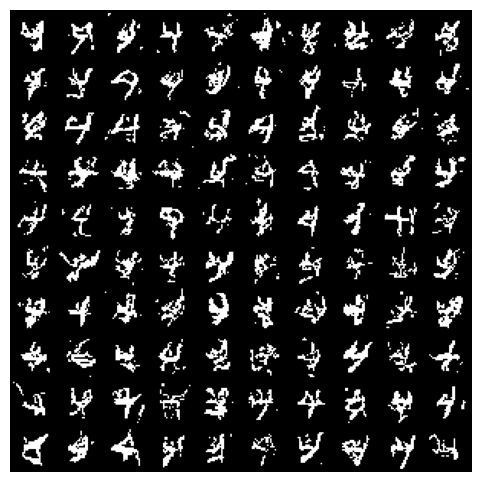

In [35]:
# Visualize samples from the mixture model
with torch.no_grad():
    samples = sample_mixture_model(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()